In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as optimize
import string
import datetime
from Zeesluisformulering import Zeesluis_Formulering as ZSF
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

### Data Processing

In [2]:
with open('ship_passages_NWW_2019.pickle', 'rb') as handle:
    schependf = pickle.load(handle)

In [3]:
schependf = schependf[(schependf['length'] < 500) & (schependf['width'] < 70) & (schependf['draughtMarine'] < 16.2)]
schependf['WaterVolume'] = (0.8 * schependf['length'] * schependf['width'] * schependf['draughtMarine']).round(1)

# CHOOSE NUMBER OF LOCKS & DATASET FOR LOCKDESIGN (OPTIMIZATION)

In [4]:
number_of_locks = 5 # must be > 1

einde = pd.Timestamp(year=2019, month=1, day=8, tz='UTC')
subset = schependf[schependf.arrival < einde]

### Lock Class

In [5]:
class IsLock():
    def __init__(self,L,B,D,direction,invaartijd,uitvaartijd,schuttijd,deur_open_sluit_tijd):
        self.L = L
        self.B = B
        self.D = D
        self.direction = direction
        self.invaartijd = invaartijd
        self.uitvaartijd = uitvaartijd
        self.schuttijd = schuttijd
        self.deur_open_sluit_tijd = deur_open_sluit_tijd
        self.tijd = pd.Timestamp('2019-01-01T00:00:00',tz='UTC')
        self.lockages = pd.DataFrame(columns=['Vessels','Start time','Stop time'])
        
    def add_to_lockages(self,total_time,vessel='',shipvolume=''):
        index = len(self.lockages)
        self.lockages.loc[index,'Vessels'] = vessel
        self.lockages.loc[index,'Direction'] = self.direction
        self.lockages.loc[index,'Start time'] = self.tijd
        self.lockages.loc[index,'Stop time'] = self.tijd+total_time
        self.lockages.loc[index,'Ship Watervolume'] = shipvolume
    
    def initiate_lockage(self,total_time=np.timedelta64(0,'s'),vessel='',empty=False, shipvolume=0):
        if empty:
            total_time = np.max([self.schuttijd+2*self.deur_open_sluit_tijd,total_time])
            self.add_to_lockages(total_time,vessel,shipvolume)
        else:
            total_time = self.invaartijd+self.schuttijd+self.uitvaartijd+2*self.deur_open_sluit_tijd
            self.add_to_lockages(total_time,vessel,shipvolume)
            
        if self.direction == 'inbound':
            self.direction = 'outbound'
        else:
            self.direction = 'inbound'
            
        self.tijd += total_time
        
        return total_time

### Lock Complex Simulator

In [6]:
def lock_complex(Draught, Width, Length, shipdata):
    number_of_locks = len(Draught + 1)
    draughtlist = []
    widthlist = []
    lengthlist = []
    locks = []
    for i in range(number_of_locks-1):
        draughtlist = np.append(draughtlist, Draught[i])
        widthlist = np.append(widthlist, Width[i])
        lengthlist = np.append(lengthlist, Length[i])
        locks = np.append(locks, IsLock(lengthlist[i], widthlist[i], draughtlist[i],'inbound',np.timedelta64(30,'m'),np.timedelta64(15,'m'),np.timedelta64(30,'m'),np.timedelta64(10,'m')))
    locklast = IsLock(500, 70, 17, 'inbound',np.timedelta64(30,'m'),np.timedelta64(30,'m'),np.timedelta64(15,'m'),np.timedelta64(10,'m'))
    locks = np.append(locks, locklast)
    lockletter = list(string.ascii_uppercase)[0:number_of_locks]
    
    for index,ship in shipdata.iterrows():
        for lockindex, lock in enumerate(locks):
            if (ship.draughtMarine < lock.D)&(ship.length < lock.L)&(ship.width < lock.B):
                    break
        waiting_time = np.timedelta64(0,'s')
            
        #If lock doors are open in opposite direction
        if lock.direction != ship.direction:
            waiting_time = lock.initiate_lockage(empty=True) 

        #If lock is inbound, but still in progress
        if lock.tijd > ship.arrival:
            waiting_time += lock.tijd-ship.arrival
            
        #If ship arrival lies ahead
        elif ship.arrival > lock.tijd:
            lock.tijd = ship.arrival

        #Lockage when ready
        waiting_time += lock.initiate_lockage(waiting_time,ship['name'],shipvolume=ship['WaterVolume']) 
            
        shipdata.loc[index, 'waiting time'] = waiting_time
        shipdata.loc[index, 'Lock'] = lockletter[lockindex]

    Mean_Waitingtime = shipdata[shipdata.arrival < einde]['waiting time'].mean()

    lockindexdf = []
    lockletter = list(string.ascii_uppercase)[0:number_of_locks]
    for i in range(number_of_locks):
        lockindexdf = np.append(lockindexdf, 'Lock '+ lockletter[i])

    MeanWaitingTime_list = []
    for i in range(number_of_locks):
        MeanWaitingTime_list = np.append(MeanWaitingTime_list, shipdata[(shipdata.arrival < einde)&(shipdata.Lock == lockletter[i])]['waiting time'].mean())
    MeanWaitingTime_list = np.append(MeanWaitingTime_list, Mean_Waitingtime)
    waitingtime_df = pd.DataFrame({'Average Waiting Time': MeanWaitingTime_list}, index=np.append(lockindexdf, 'Overall'))

    Mean_Waitingtime_Integer = Mean_Waitingtime / pd.Timedelta(seconds=1)

    return Mean_Waitingtime_Integer, waitingtime_df, locks, shipdata

### Optimization Lock Dimensions (TAKES TIME!!!)

In [8]:
initial_guess = []
subset_sorted = subset.sort_values('draughtMarine')
width_guess = 70 * np.ones(number_of_locks-1)
length_guess = 500 * np.ones(number_of_locks-1)
for i in range(number_of_locks-1):
    initial_guess = np.append(initial_guess, subset_sorted.iloc[int(len(subset)*((i+1)/number_of_locks))-1]['draughtMarine'])
# print(initial_guess)

result = optimize.basinhopping(lambda x: lock_complex(x, width_guess, length_guess, subset)[0], x0=initial_guess) 
if result.success:
    fitted_params = result.x
else:
    raise ValueError(result.message)

In [9]:
vesseldepth = np.append(fitted_params, 17)
vessellength =[]
vesselwidth = []

for i in range(len(fitted_params)):
    vessellength = np.append(vessellength, subset[subset['draughtMarine'] < fitted_params[i]]['length'].max()) 
    vesselwidth = np.append(vesselwidth, subset[subset['draughtMarine'] < fitted_params[i]]['width'].max()) 
margin = 0.1 * np.ones(len(fitted_params))
vessellength = vessellength + margin
vesselwidth = vesselwidth + margin

library_dimensions = {'Length [m]': np.append(vessellength, 500), 'Width [m]':  np.append(vesselwidth, 70), 'Depth [m]': vesseldepth}
lockindexdf = []
lockletter = list(string.ascii_uppercase)[0:number_of_locks]
for i in range(number_of_locks):
    lockindexdf = np.append(lockindexdf, 'Lock '+ lockletter[i])
LockDimensionCriteria = pd.DataFrame(library_dimensions, index=lockindexdf)

# CHOOSE DATA SET FOR LOCK SIMULATION

In [10]:
einde = pd.Timestamp(year=2020, month=3, day=1, tz='UTC')
subset = schependf[schependf.arrival < einde]

# Interim Results

In [11]:
display(LockDimensionCriteria)
waitingtime_int, waitingtime_df, locks, subset = lock_complex(LockDimensionCriteria['Depth [m]'], LockDimensionCriteria['Width [m]'], LockDimensionCriteria['Length [m]'], subset)

,Length [m],Width [m],Depth [m]
Lock A,143.1,23.1,5.037049
Lock B,209.1,31.1,6.135584
Lock C,229.1,38.1,7.092659
Lock D,229.1,38.1,7.687809
Lock E,500.0,70.0,17.000000


In [12]:
# LockDimensionCriteria.to_csv('5 locks/lockdimensionscriteria.xlsx')
# waitingtime_df.to_csv('5 locks/waitingtime_df.xlsx')
# locks[0].lockages.to_csv('5 locks/lockages1.xlsx')
# schependf.to_csv('5 locks/schependf.xlsx')

In [13]:
# locks[2].lockages
# locks[2].lockages.to_csv('5locks-13jan/locks2lockages.csv')

# IMPLEMENTING ZSF

In [14]:
Lengths = []
Widths = []
Depths = []
for i in range(len(locks)):
    Length = round(LockDimensionCriteria.iloc[i]['Length [m]'] + 13, -1)
    Lengths = np.append(Lengths, Length)
    Width = round(LockDimensionCriteria.iloc[i]['Width [m]'] + 11, -1)
    Widths = np.append(Widths, Width)
    Depth = round(LockDimensionCriteria.iloc[i]['Depth [m]'] + 1)
    Depths = np.append(Depths, Depth)

DimensionsLibrary = {'Length [m]':Lengths, 'Width [m]':Widths, 'Depth [m]':Depths}
LockDimensions = pd.DataFrame(DimensionsLibrary, index = lockindexdf)
# display(LockDimensions)

LockDimensions['nr of cycles'] = np.zeros(len(LockDimensions))
LockDimensions['Salt per cycle [tons]'] = np.zeros(len(LockDimensions))
LockDimensions['Salt [kg/s]'] = np.zeros(len(LockDimensions))

In [15]:
for j in range(len(LockDimensions)):
    Lock = LockDimensions.iloc[j]
    lockages = locks[j].lockages
    
    Length, Width, Depth, extra1, extra2, extra3 = Lock
    Vopwmean = lockages[lockages['Direction'] == 'inbound']['Ship Watervolume'].mean()
    Vafmean = lockages[lockages['Direction'] == 'outbound']['Ship Watervolume'].mean()
    n_cycl = round((len(lockages)/2)/((lockages['Stop time'].iloc[-1] - lockages['Start time'].iloc[0])/np.timedelta64(24,'h')))

    invaartijd, uitvaartijd, schuttijd, deur_open_sluit_tijd = np.timedelta64(30,'m'),np.timedelta64(15,'m'),np.timedelta64(30,'m'),np.timedelta64(10,'m')
    Total_Door_Opentime = np.timedelta64(0,'h')

    for i in range(len(lockages)):
        #Door open time per lockage (dependent on presence of vessel)
        if lockages['Vessels'].isnull()[i]:
            Total_Door_Opentime += 2*deur_open_sluit_tijd
        else: 
            Total_Door_Opentime += 2*deur_open_sluit_tijd + invaartijd + uitvaartijd
        
        if i == len(lockages)-1:
            break
        #If for longer than twice door open/close time no vessel starts locking, doors are closed
        if lockages['Start time'].iloc[i+1] - lockages['Stop time'].iloc[i] > 2*deur_open_sluit_tijd + np.timedelta64(5, 'm'):
            Total_Door_Opentime += np.timedelta64(2*deur_open_sluit_tijd)
        #If that's not the case, doors remain open
        else:
            Total_Door_Opentime += lockages['Start time'].iloc[i+1] - lockages['Stop time'].iloc[i]
    T_D_calc = Total_Door_Opentime/round(len(lockages)/2)/np.timedelta64(1, 's')
    T_niv_calc = schuttijd/np.timedelta64(1, 's')
    
    LockDimensions['nr of cycles'].iloc[j] = round(len(lockages)/2)
    LockDimensions['Salt per cycle [tons]'].iloc[j] = ZSF(L_K=Length, B_K=Width, Z_K=Depth, V_opw=Vopwmean, V_afw=Vafmean, T_D=T_D_calc, T_niv=T_niv_calc, N_cyc=n_cycl, Z_VZ=16.3, Z_VM=16.3)[0]/1000
    LockDimensions['Salt [kg/s]'].iloc[j] = ZSF(L_K=Length, B_K=Width, Z_K=Depth, V_opw=Vopwmean, V_afw=Vafmean, T_D=T_D_calc, T_niv=T_niv_calc, N_cyc=n_cycl, Z_VZ=16.3, Z_VM=16.3)[1]

In [16]:
totalsalt = 0
for i in range(len(LockDimensions)):
    totalsalt += LockDimensions.iloc[i]['Salt per cycle [tons]'] * LockDimensions.iloc[i]['nr of cycles']
saltpercycle = totalsalt / LockDimensions['nr of cycles'].sum()

In [17]:
Average = ['-', '-', '-', LockDimensions['nr of cycles'].sum(), saltpercycle, LockDimensions['Salt [kg/s]'].sum()]
LockDimensions.loc[len(LockDimensions.index)] = Average
index_list = LockDimensions.index.tolist()
index_list[-1] = 'Overall'
LockDimensions.index = index_list
LockDimensions['Waiting Time'] = waitingtime_df['Average Waiting Time']
LockResults = LockDimensions

# Final Results

In [18]:
display(LockResults)

,Length [m],Width [m],Depth [m],nr of cycles,Salt per cycle [tons],Salt [kg/s],Waiting Time
Lock A,160.0,30.0,6.0,6578.0,759.617972,79.126872,182 days 20:02:49
Lock B,220.0,40.0,7.0,5004.0,1563.697863,162.885194,89 days 04:18:14
Lock C,240.0,50.0,8.0,6406.0,2212.466116,230.465220,172 days 19:40:06
Lock D,240.0,50.0,9.0,2709.0,2312.477711,187.353518,0 days 08:09:39
Lock E,510.0,80.0,18.0,3828.0,20973.188351,2427.452355,22 days 05:27:44
Overall,-,-,-,24525.0,4629.742556,3087.283160,115 days 08:23:13


In [19]:
#data per vessel
display(subset)

#data on lockages per lock
display(locks[1].lockages) ## [0]=LockA, [1]=lockB etc.

,name,direction,length,width,draughtMarine,arrival,WaterVolume,waiting time,Lock
0,testschip-1355,inbound,140.0,22.0,7.0,2019-01-01 03:00:19+00:00,17248.0,0 days 01:35:00,C
1,testschip-1364,inbound,144.0,23.0,8.4,2019-01-01 04:18:29+00:00,22256.6,0 days 01:35:00,E
2,testschip-1379,inbound,210.0,32.0,10.6,2019-01-01 05:57:41+00:00,56985.6,0 days 02:40:48,E
3,testschip-1131,outbound,144.0,25.0,9.6,2019-01-01 06:27:41+00:00,27648.0,0 days 03:10:48,E
4,testschip-1186,outbound,94.0,12.0,4.4,2019-01-01 06:39:10+00:00,3970.6,0 days 02:25:00,A
...,...,...,...,...,...,...,...,...,...
32693,testschip-1355,outbound,140.0,22.0,6.6,2019-12-31 18:36:34+00:00,16262.4,344 days 15:53:38,C
32694,testschip-3546,outbound,110.0,14.0,4.2,2019-12-31 19:17:06+00:00,5174.4,358 days 00:42:04,A
32695,testschip-1791,inbound,89.0,13.0,4.6,2019-12-31 20:52:10+00:00,4257.8,357 days 23:52:00,A
32696,testschip-447,outbound,101.0,18.0,6.2,2019-12-31 22:38:43+00:00,9017.3,344 days 14:16:29,C


,Vessels,Start time,Stop time,Direction,Ship Watervolume
0,,2019-01-01 00:00:00+00:00,2019-01-01 00:50:00+00:00,inbound,0.0
1,testschip-922,2019-01-01 08:31:37+00:00,2019-01-01 10:06:37+00:00,outbound,16861.8
2,,2019-01-01 10:06:37+00:00,2019-01-01 10:56:37+00:00,inbound,0.0
3,testschip-364,2019-01-01 10:56:37+00:00,2019-01-01 12:31:37+00:00,outbound,6988.8
4,,2019-01-01 12:31:37+00:00,2019-01-01 13:21:37+00:00,inbound,0.0
...,...,...,...,...,...
10004,testschip-16654,2020-07-07 01:12:03+00:00,2020-07-07 02:47:03+00:00,inbound,5416.3
10005,testschip-4352,2020-07-07 02:47:03+00:00,2020-07-07 04:22:03+00:00,outbound,9139.2
10006,,2020-07-07 04:22:03+00:00,2020-07-07 05:12:03+00:00,inbound,0.0
10007,testschip-4776,2020-07-07 05:12:03+00:00,2020-07-07 06:47:03+00:00,outbound,13104.0


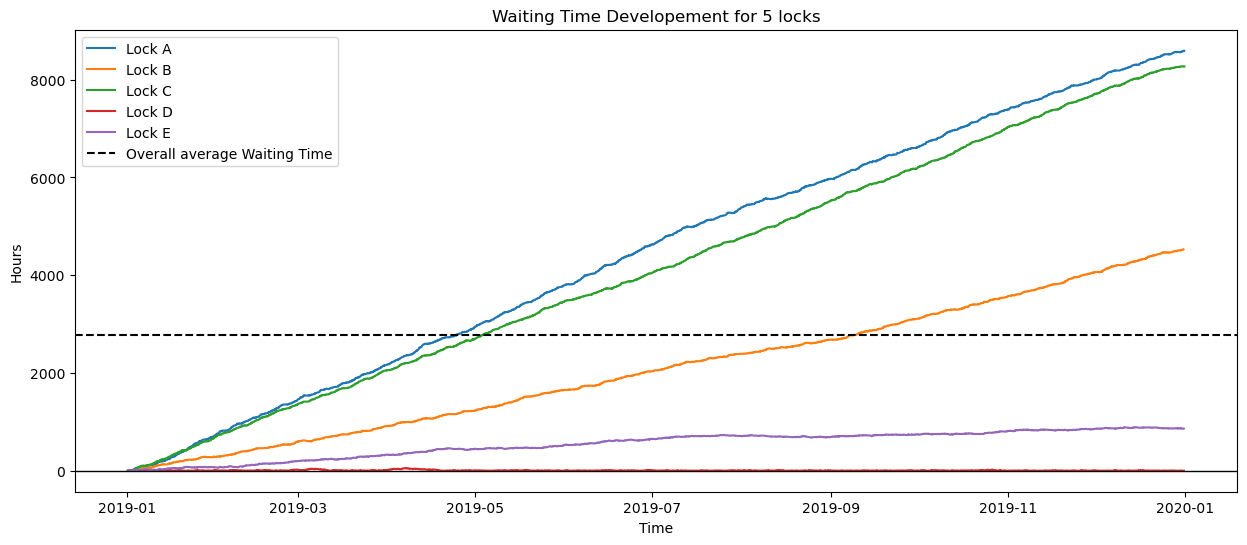

In [20]:
plt.figure(figsize=(15, 6))
for i in range(len(lockletter)):
    plt.plot(subset[subset['Lock'] == lockletter[i]]['arrival'], (subset[subset['Lock'] == lockletter[i]]['waiting time'])/pd.Timedelta(hours=1), label=lockindexdf[i])
plt.axhline(waitingtime_df['Average Waiting Time'][-1]/pd.Timedelta(hours=1), ls='--', color='black', label='Overall average Waiting Time')
plt.title(f'Waiting Time Developement for {len(lockletter)} locks')
plt.ylabel('Hours')
plt.xlabel('Time')
plt.legend()
# plt.grid()
plt.axhline(0, lw=1, color='black');
plt.savefig('15locks.jpg');

In [21]:
print(LockResults.to_latex(float_format="%.2f"))

\begin{tabular}{llllrrrl}
\toprule
 & Length [m] & Width [m] & Depth [m] & nr of cycles & Salt per cycle [tons] & Salt [kg/s] & Waiting Time \\
\midrule
Lock A & 160.00 & 30.00 & 6.00 & 6578.00 & 759.62 & 79.13 & 182 days 20:02:49 \\
Lock B & 220.00 & 40.00 & 7.00 & 5004.00 & 1563.70 & 162.89 & 89 days 04:18:14 \\
Lock C & 240.00 & 50.00 & 8.00 & 6406.00 & 2212.47 & 230.47 & 172 days 19:40:06 \\
Lock D & 240.00 & 50.00 & 9.00 & 2709.00 & 2312.48 & 187.35 & 0 days 08:09:39 \\
Lock E & 510.00 & 80.00 & 18.00 & 3828.00 & 20973.19 & 2427.45 & 22 days 05:27:44 \\
Overall & - & - & - & 24525.00 & 4629.74 & 3087.28 & 115 days 08:23:13 \\
\bottomrule
\end{tabular}



In [22]:
LockResults

,Length [m],Width [m],Depth [m],nr of cycles,Salt per cycle [tons],Salt [kg/s],Waiting Time
Lock A,160.0,30.0,6.0,6578.0,759.617972,79.126872,182 days 20:02:49
Lock B,220.0,40.0,7.0,5004.0,1563.697863,162.885194,89 days 04:18:14
Lock C,240.0,50.0,8.0,6406.0,2212.466116,230.465220,172 days 19:40:06
Lock D,240.0,50.0,9.0,2709.0,2312.477711,187.353518,0 days 08:09:39
Lock E,510.0,80.0,18.0,3828.0,20973.188351,2427.452355,22 days 05:27:44
Overall,-,-,-,24525.0,4629.742556,3087.283160,115 days 08:23:13
